In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from collections import namedtuple
import numpy as np
import cupy as cp
import math

%run kernel.ipynb

4.72 μs ± 24 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.77 μs ± 62.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [2]:
config = Config()

In [3]:
%%time
IMAGES = []
IMAGE_FNAMES = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        IMAGE_FNAMES[image_index] = image_fname
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGE_FNAMES)
IMAGES = np.array(IMAGES)
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9146 [00:00<?, ?it/s]

Loaded 9145 images
CPU times: user 425 ms, sys: 42 ms, total: 467 ms
Wall time: 465 ms


In [4]:
# Parameters of kernel generation. Subject to evolution
OUTLINE_WIDTH = 4/32
STRETCH_X_LEVELS = 7
STRETCH_Y_LEVELS = 7
ROTATION_LEVELS = 12
OFFSET_X_LEVELS = 5
OFFSET_Y_LEVELS = 5

assert STRETCH_X_LEVELS > 0 and STRETCH_X_LEVELS % 2
assert STRETCH_Y_LEVELS > 0 and STRETCH_Y_LEVELS % 2
assert OFFSET_X_LEVELS > 0 and OFFSET_X_LEVELS % 2
assert OFFSET_Y_LEVELS > 0 and OFFSET_Y_LEVELS % 2

In [7]:
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
offset_x_transfs = []
offset_y_transfs = []

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_X_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_X_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_X_LEVELS // 2))
    transf = [
        [u, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))
    transf = [
        [d, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 2x to 0.25x including 1
for i in range(STRETCH_Y_LEVELS // 2):
    u = (1.0 + (i + 1) * (2 - 1) / (STRETCH_Y_LEVELS // 2))
    d = (1.0 - (i + 1) * (1 - 0.25) / (STRETCH_Y_LEVELS // 2))
    transf = [
        [1, 0, 0],
        [0, u, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, d, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_X_LEVELS // 2):
    l = 1 / ((OFFSET_X_LEVELS - 1) // 2) * (i + 1)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_x_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
for i in range(OFFSET_Y_LEVELS // 2):
    u = 1 / ((OFFSET_Y_LEVELS - 1) // 2) * (i + 1)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

transf = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]
offset_y_transfs.append(np.array(transf))

In [8]:
TRANSFS = []
break_on_transf = -1
i = 0

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    if break_on_transf > 0 and i == break_on_transf:
                         assert False
                    # https://learn.microsoft.com/en-us/dotnet/desktop/winforms/advanced/why-transformation-order-is-significant?view=netframeworkdesktop-4.8
                    # We need first scale, then rotate (around origin), then translate
                    transf = e @ d @ c @ b @ a
                    TRANSFS.append(transf)
                    i += 1

In [9]:
len(TRANSFS)

14700

In [10]:
def draw_kernel(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image

In [11]:
def get_kernel_size(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return size
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel.shape[0]

In [12]:
def get_kernel_shape(kernel):
    sz = get_kernel_size(kernel)
    return (sz, sz)

In [13]:
def kernel_as_matrix(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return kernel.reshape(size, size).astype(np.uint8)
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel

In [14]:
def kernel_as_image(kernel):
    data = (kernel * 255).astype(np.uint8)
    return Image.frombytes('L', size=get_kernel_shape(kernel), data=data)

In [15]:
def display_kernel_raw(kernel):
    kernel = kernel_as_matrix(kernel)
    
    for r in kernel:
        s = ''
        for c in r:
            s += ' ' + str(c)

        print(s)            

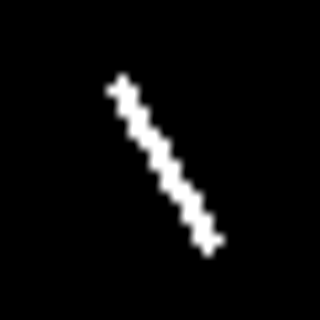

In [16]:
z = OUTLINE_WIDTH / 2
points_gold = [
    [0   - z,  0   - z,   0   + z,  0   + z ],
    [0.5 + z, -0.5 - z,  -0.5 - z,  0.5 + z ],
    [1,        1,         1,        1  ]
]
half_kernel_size = (32 - 1) / 2
transf = e @ d @ c @ b @ a
points = (transf @ points_gold).T
points_x = (points[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
points_y = (points[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
kernel_image = draw_kernel(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=int(half_kernel_size) * 2)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
kernel_as_image(kernel).resize((320, 320))

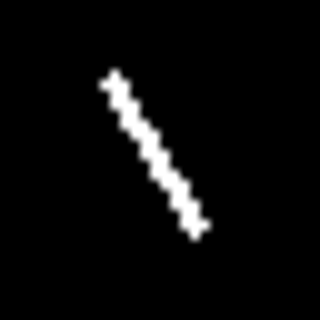

In [17]:
half_kernel_size = (config.kernel_size - 1) / 2
transf = e @ d @ c @ b @ a
points = (transf @ points_gold).T
points_x = (points[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
points_y = (points[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
kernel_image = draw_kernel(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=config.kernel_size)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
kernel_as_image(kernel).resize((320, 320))

In [18]:
half_kernel_size

15.5

In [19]:
_ppp = a @ points_gold
_ppp.T

array([[-0.0625,  0.5625,  1.    ],
       [-0.0625, -0.5625,  1.    ],
       [ 0.0625, -0.5625,  1.    ],
       [ 0.0625,  0.5625,  1.    ]])

In [20]:
_ppp2 = c @ _ppp
_ppp2.T

array([[-0.33537659,  0.45588929,  1.        ],
       [ 0.22712341, -0.51838929,  1.        ],
       [ 0.33537659, -0.45588929,  1.        ],
       [-0.22712341,  0.51838929,  1.        ]])

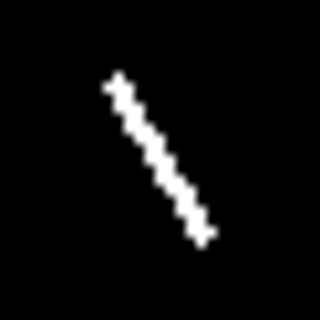

In [21]:
points_x = (_ppp2.T[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
points_y = (_ppp2.T[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
kernel_image = draw_kernel(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=int(half_kernel_size*2))
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
kernel_as_image(kernel).resize((320, 320))

In [22]:
_ppp3 = c @ points_gold
_ppp3.T

array([[-0.33537659,  0.45588929,  1.        ],
       [ 0.22712341, -0.51838929,  1.        ],
       [ 0.33537659, -0.45588929,  1.        ],
       [-0.22712341,  0.51838929,  1.        ]])

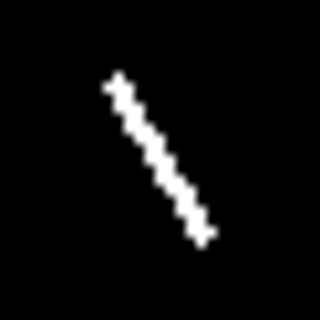

In [23]:
points_x = (_ppp3.T[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
points_y = (_ppp3.T[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
kernel_image = draw_kernel(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=int(half_kernel_size*2))
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
kernel_as_image(kernel).resize((320, 320))

In [24]:
%%time
KERNELS = []
KERNEL_PARAMS = []
KERNELS_AS_OBJ = []
half_kernel_size = (config.kernel_size - 1) / 2

# prototype is a simple vertical bar
z = OUTLINE_WIDTH / 2
points_gold = [
    [0   - z,  0   - z,   0   + z,  0   + z ],
    [0.5 + z, -0.5 - z,  -0.5 - z,  0.5 + z ],
    [1,        1,         1,        1  ]
]

for transf in TRANSFS:
    points = (transf @ points_gold).T
    points_x = (points[:,0] * half_kernel_size + half_kernel_size).astype(np.int32)
    points_y = (points[:,1] * -half_kernel_size + half_kernel_size).astype(np.int32)
    kernel_image = draw_kernel(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    kernel_unique_counts = np.unique_counts(np.append(kernel, [0, 1]))
    assert np.array_equal(kernel_unique_counts.values, [0, 1])
    ones_count = kernel_unique_counts.counts[1] - 1 # subtract 1 because it was added intentionally before (alongside with zero) 

    if ones_count <= 0: # Empty image was generated, ignore
         continue
    
    denominator = 255 * ones_count
    kernel = kernel.astype(np.float32)
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

    kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
    assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
    KERNELS_AS_OBJ.append(kernel_as_obj)

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
KERNELS_AS_OBJ = np.array(KERNELS_AS_OBJ)
assert len(KERNELS) == len(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNELS_AS_OBJ)

print(f'{len(KERNELS)} kernels generated')

14694 kernels generated
CPU times: user 8.88 s, sys: 36.1 ms, total: 8.92 s
Wall time: 8.92 s



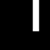
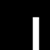
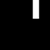
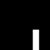
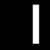
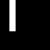
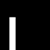
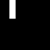
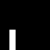
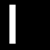
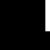
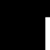
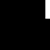
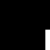
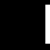
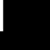
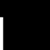
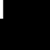
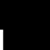
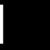
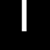
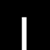
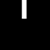
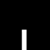
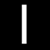
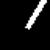
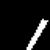
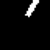
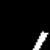
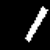
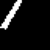
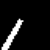
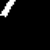
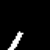
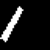
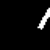
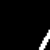
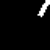
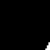
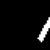
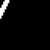
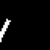
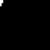
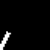
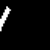
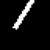
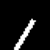
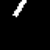
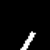
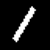
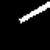
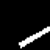
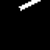
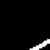
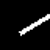
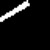
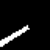
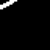
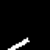
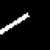
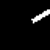
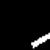
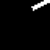
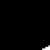
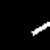
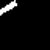
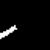
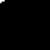
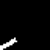
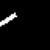
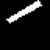
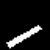
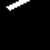
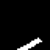
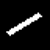
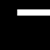
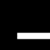
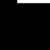
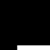
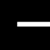
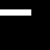
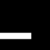
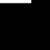
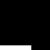
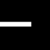
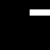
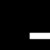
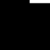
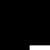
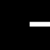
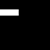
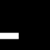
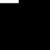
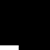
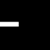
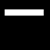
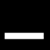
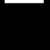
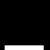
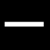
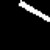
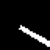
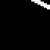
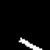
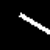
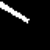
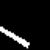
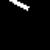
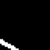
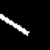
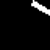
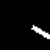
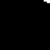
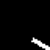
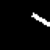
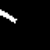
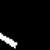
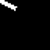
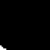
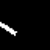
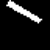
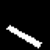
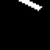
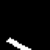
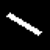
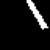
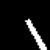
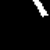
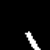
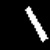
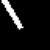
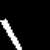
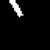
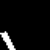
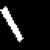
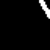
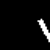
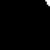
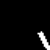
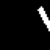
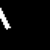
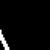
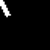
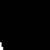
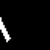
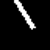
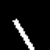
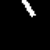
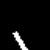
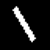
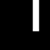
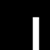
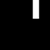
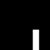
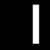
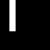
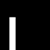
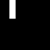
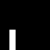
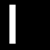
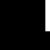
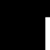
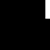
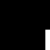
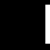
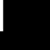
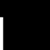
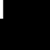
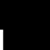
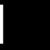
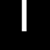
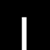
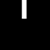
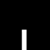
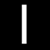
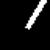
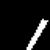
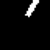
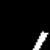
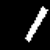
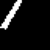
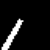
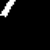
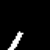
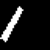
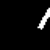
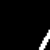
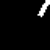
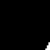
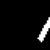
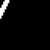
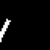
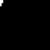
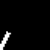
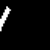
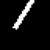
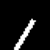
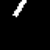
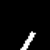
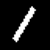
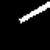
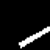
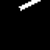
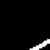
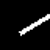
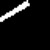
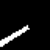
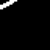
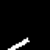
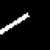
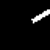
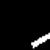
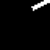
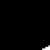
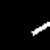
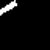
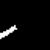
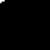
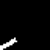
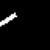
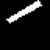
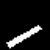
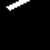
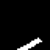
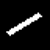
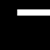
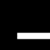
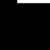
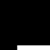
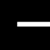
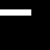
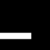
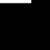
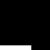
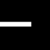
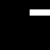
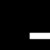
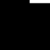
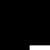
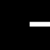
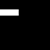
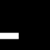
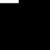
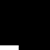
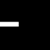
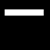
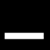
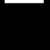
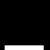
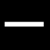
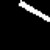
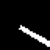
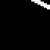
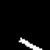
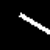
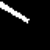

In [25]:
max_to_show = 256

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

# Turn to column vector
assert kernel_image_denoms.shape == (max_to_show,)
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
kernel_images *= 255 # turn to 0..255

_images = []
_captions = dict()

for i in range(kernel_images.shape[0]):
    _image = Image.frombytes('L', size=get_kernel_shape(kernel_images[i]), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    _captions[id(_image)] = i
    
display_images_grid(_images, 16, captions=_captions)

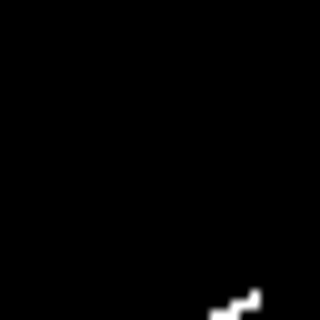

In [26]:
kernel_as_image(KERNELS[12199]).resize((320, 320))

In [53]:
%%time

kernel_denoms = KERNEL_PARAMS[:,1]
kernel_denoms = kernel_denoms.reshape(1,-1).T # turn to column vector (many rows, single column)
KERNELS_SCALED = KERNELS / kernel_denoms 
MATCH_MATRIX_RAW = IMAGES @ KERNELS.T
MATCH_MATRIX_SCALED = IMAGES @ KERNELS_SCALED.T

CPU times: user 27.1 s, sys: 12.6 s, total: 39.7 s
Wall time: 3.4 s


In [57]:
# verify correctness vs Kernel POJO
image_random_indices = np.random.randint(len(IMAGES), size=(100,))
kernel_random_indices = np.random.randint(len(KERNELS), size=(100,))

for i in image_random_indices:
    for j in kernel_random_indices:
        match_score1 = MATCH_MATRIX_SCALED[i,j]
        image = IMAGES[i].reshape(config.kernel_size, config.kernel_size)
        kernel = KERNELS_AS_OBJ[j]
        assert np.array_equal(kernel.m, KERNELS[j].reshape(config.kernel_size, config.kernel_size))
        match_score2 = kernel.match(image, 0.01)[1]
        assert np.isclose(match_score1, match_score2), (i, j, match_score1, match_score2)

In [59]:
success_matches = MATCH_MATRIX_SCALED > config.kernel_match_threshold # which kernels were turned on
success_matches = success_matches @ np.full((MATCH_MATRIX_SCALED.shape[1],), 1 / MATCH_MATRIX_SCALED.shape[1]) # percentage of kernels which were turned on for each image
success_matches_count = (success_matches > config.kernel_grid_match_threshold) @ np.full((MATCH_MATRIX_SCALED.shape[0],), 1)
success_matches_count / len(IMAGES)

np.float64(0.14477856752323673)

In [60]:
thres_to_percentage = []
z = np.full((MATCH_MATRIX_SCALED.shape[0],), 1)
interesting_points = [
    [0.99, None], 
    [0.95, None],
    [0.9, None],
    [0.8, None],
    [0.5, None]
]

for thres in range(100):
    point = thres / 100
    x = (success_matches > point) @ z
    x = x / len(IMAGES)
    thres_to_percentage.append([point, x])

    for ip in interesting_points:
        if x < ip[0] and ip[1] is None:
            ip[1] = point
            break

thres_to_percentage = np.array(thres_to_percentage)

In [31]:
interesting_points

[[0.99, 0.01], [0.95, 0.02], [0.9, 0.03], [0.8, 0.04], [0.5, 0.05]]

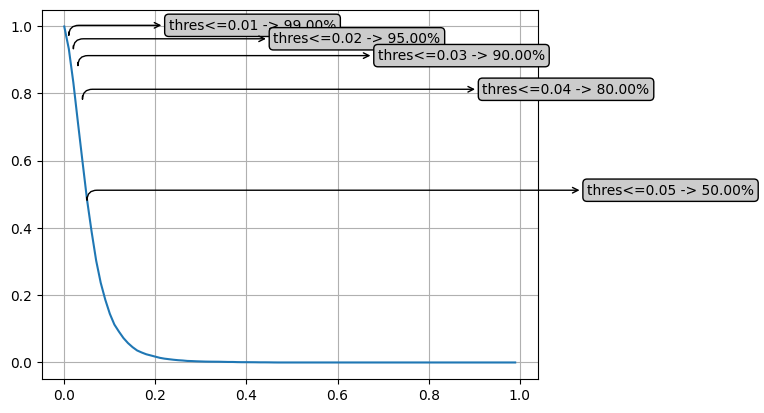

In [32]:
fig, ax = plt.subplots()
offset = -72
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="<-",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.plot(thres_to_percentage[:,0], thres_to_percentage[:,1])

for i, ip in enumerate(interesting_points):
    ax.annotate(
        f'thres<={ip[1]} -> {ip[0]*100:.2f}%',
        (ip[1], ip[0]),
        xytext=(-(i+1)*offset,0), textcoords='offset points',
        bbox=bbox, arrowprops=arrowprops)
ax.grid()
plt.show()


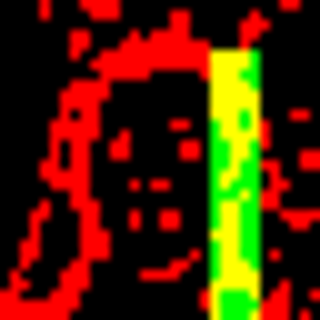
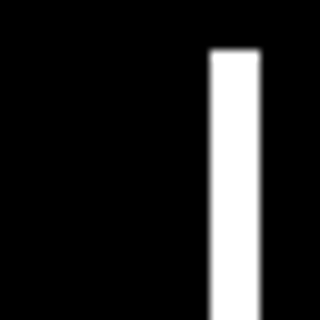

In [112]:
image_index = np.random.randint(MATCH_MATRIX_SCALED.shape[0])
image_fname = IMAGE_FNAMES[image_index]
image = Image.open(image_fname)

kernel_on_offs = MATCH_MATRIX_SCALED[image_index] > config.kernel_match_threshold
kernel_match_scores = MATCH_MATRIX_RAW[image_index] * kernel_on_offs

for on_off, raw, score in zip(kernel_on_offs, MATCH_MATRIX_RAW[image_index], kernel_match_scores):
    assert int(on_off) * raw == score
    
best_kernel_match_index = np.argmax(kernel_match_scores)
assert best_kernel_match_index >= 0
assert best_kernel_match_index < MATCH_MATRIX_RAW.shape[1]

kernel = KERNELS[best_kernel_match_index]
kernel_image = Image.frombytes('L', size=get_kernel_shape(kernel), data=(kernel * 255).astype(np.uint8))
kernel_image_for_display = kernel_image.resize((320, 320))

image_plus_kernel = Image.merge('RGB', (image, kernel_image, image.point(lambda _: 0))).resize((320, 320))

captions = {
    id(image_plus_kernel): f'''{image_index} ({image_fname}) 
    {MATCH_MATRIX_SCALED[image_index][best_kernel_match_index]*100:.2f}% {kernel_match_scores[best_kernel_match_index]}''',
    id(kernel_image_for_display): f'{best_kernel_match_index}' 
}
display_images([image_plus_kernel, kernel_image_for_display], captions=captions)